In [14]:
import json
import pandas as pd
import plotly.graph_objects as go
from plotly.colors import DEFAULT_PLOTLY_COLORS as colors
from collections import defaultdict


In [15]:
def get_normalized_read_counts(df):
    accession = df['accession']
    if df['library'] == 'RNA':
        normalized_reads = 'rna_normalized_reads'
    elif df['library'] == 'DNA':
        normalized_reads = 'dna_normalized_reads'
    name_ls, normalized_reads_ls, taxid_ls = [], [], []
    for key in output[accession]:
        if key not in non_organism_keys and normalized_reads in output[accession][key]:
            normalized_reads_ls.append(output[accession][key][normalized_reads])
            name_ls.append(output[accession][key]['organism_name'])
            taxid_ls.append(key)
    return normalized_reads_ls, taxid_ls, name_ls

In [16]:
with open('all_organism_results.json') as infile:
    output = json.load(infile)
sample_info = pd.read_excel('ecoli_results_annotated.xlsx')
sample_info['library'] = sample_info['library'].replace({'DNA ': 'DNA'})

set_ls = []
non_organism_keys = ['t7_coverage', 't7_normalized_reads', 't4_coverage',
    't4_normalized_reads', 'ms2_coverage', 'ms2_normalized_reads',
    'qbeta_coverage', 'qbeta_normalized_reads']
for accession in output.keys():
    set_ls.append(set([key for key in output[accession].keys()
                  if key not in non_organism_keys]))

In [17]:
common_organisms = set.intersection(*set_ls)
print(f"Organisms detected in all samples: {len(common_organisms)}")

# Get normalized read count for all organisms surpassing 0.7 coverage threshold.
sample_info[['normalized_reads', 'taxids', 'organism_names']] = \
    pd.DataFrame(sample_info.apply(get_normalized_read_counts, axis=1).tolist(),
                 index=sample_info.index)

Organisms detected in all samples: 0


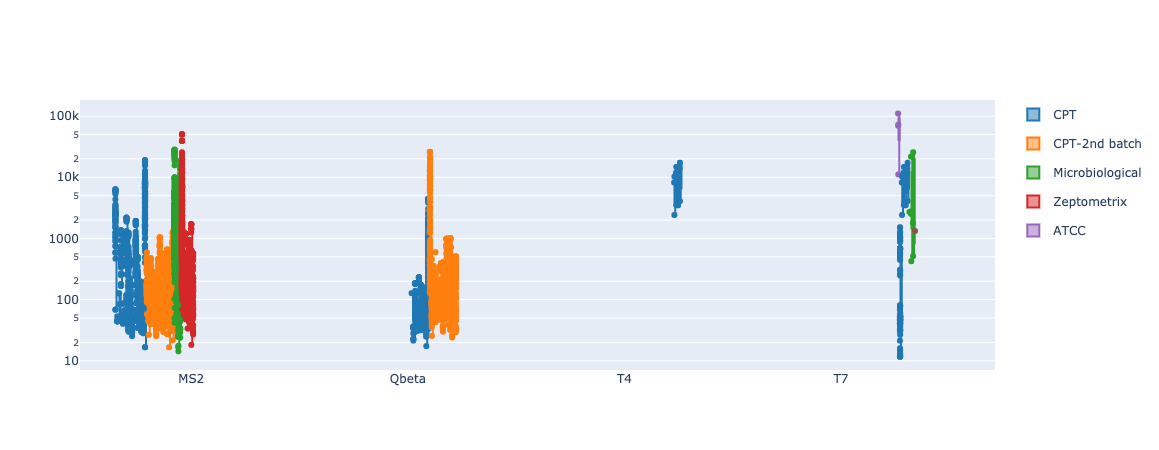

In [18]:
group_counter = defaultdict(int)
color_dict = dict(zip(sample_info['source'].unique(), colors))
fig = go.Figure()
for idx, row in sample_info.iterrows():
    group_counter[row['source']] += 1
    if group_counter[row['source']] > 1:
        showlegend = False
    else:
        showlegend = True
    text_taxids = row['taxids']
    text_names = row['organism_names']
    y_vals = row['normalized_reads']
    if not y_vals:
        continue
    x_vals = [row['phage']] * len(y_vals)
    text_accession = [row['accession']] * len(y_vals)
    hovertext = [f"Accession: {acc}<br>Taxid: {tax}<br>Name: {name}<br>Normalized reads: {norm_reads}"
                 for acc, tax, name, norm_reads in
                 zip(text_accession, text_taxids, text_names, y_vals)]
    fig.add_trace(
        go.Box(
            x=x_vals,
            y=y_vals,
            name=row['source'],
            legendgroup=row['source'],
            marker_color=color_dict[row['source']],
            hovertext=hovertext,
            hoverinfo='text',
            showlegend=showlegend,
            boxpoints='all'
        )
    )
fig.update_yaxes(type='log')
fig.update_layout(boxmode='group')
fig.show()